# Seqeunce Model with Attention for Addition Learning


- This notebook uses two types of Attention layers:
  - Two types of Attention layers are avaiable in `tensorflow.keras`, i.e., `keras.layers.Attention` (Luong attention) and `keras.layers.AdditiveAttention` (Bahdanau attention). (Please update `tensorflow` to the most recent version).
  - The second type is developed by Thushan.


## Set up Dependencies

In [32]:
import re
import tensorflow
import numpy as np
from random import randint
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Concatenate, TimeDistributed, RepeatVector, Attention, AdditiveAttention
from keras import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.utils import plot_model

In [2]:
print('Tensorflow Version: ', tensorflow.__version__)

Tensorflow Version:  2.4.1


## DL Hyperparameters

In [3]:
batch_size = 64  # Batch size for training.
epochs = 20  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

## Data Preprocessing

In [4]:
data_path = '../../../RepositoryData/data/deep-learning-2/addition.txt'

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

input_texts=[l.split('_')[0] for l in lines]
target_texts=[l.split('_')[-1].strip() for l in lines]

target_texts = ['_' + sent + '_' for sent in target_texts]

np.random.seed(123)

inds = np.arange(len(input_texts))
np.random.shuffle(inds)

## Train-Test Split

In [5]:
train_test_ratio =0.9
train_size = int(round(len(lines)*train_test_ratio))
train_inds = inds[:train_size]
test_inds = inds[train_size:]

tr_input_texts = [input_texts[ti] for ti in train_inds]
tr_target_texts = [target_texts[ti] for ti in train_inds]

ts_input_texts = [input_texts[ti] for ti in test_inds]
ts_target_texts = [target_texts[ti] for ti in test_inds]
    

In [6]:
tr_input_texts[:10]

['27+673 ',
 '153+27 ',
 '93+901 ',
 '243+678',
 '269+46 ',
 '235+891',
 '46+290 ',
 '324+947',
 '721+49 ',
 '535+7  ']

In [7]:
tr_target_texts[:10]

['_700_',
 '_180_',
 '_994_',
 '_921_',
 '_315_',
 '_1126_',
 '_336_',
 '_1271_',
 '_770_',
 '_542_']

In [8]:
print('Number of Samples:', len(lines))
print('Number of Samples in Training:', len(tr_input_texts))
print('Number of Samples in Testing:', len(ts_input_texts))

Number of Samples: 50001
Number of Samples in Training: 45001
Number of Samples in Testing: 5000


## Data Preprocessing

![](../images/text-seq-onehot-embedding.jpeg)

### Text to Sequences

- Tokenization of input and target texts invovles the following important steps:
    - Create a `Tokenizer`
    - Fit the `Tokenizer` on the training sets
    - Tokenize input and target texts of the training set into sequences
    - Identify the maxlen of the input and target texts
    - Pad input and text sequences to uniform lengths

In [9]:
# """ Defining tokenizers """
input_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK', char_level=True)
input_tokenizer.fit_on_texts(tr_input_texts)
encoder_input_sequences = input_tokenizer.texts_to_sequences(tr_input_texts)
input_maxlen = np.max([len(l) for l in encoder_input_sequences])
encoder_input_sequences = pad_sequences(encoder_input_sequences, padding='post', maxlen = input_maxlen)


target_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK', char_level=True)
target_tokenizer.fit_on_texts(tr_target_texts)
target_sequences = target_tokenizer.texts_to_sequences(tr_target_texts)
target_maxlen = np.max([len(l) for l in target_sequences])
target_sequences = pad_sequences(target_sequences, padding='post', maxlen = target_maxlen)

In [10]:
# Shapes of Input and Target Sequences
print(encoder_input_sequences.shape)
print(target_sequences.shape)

(45001, 7)
(45001, 6)


In [11]:
# ### vocab size
input_vsize = max(input_tokenizer.index_word.keys()) + 1
target_vsize = max(target_tokenizer.index_word.keys()) + 1

In [12]:
print(input_vsize)
print(target_vsize)

14
13


In [13]:
tr_input_texts[:5]

['27+673 ', '153+27 ', '93+901 ', '243+678', '269+46 ']

In [14]:
encoder_input_sequences[:5]

array([[11, 12,  3,  9, 12,  7,  2],
       [10,  8,  7,  3, 11, 12,  2],
       [ 4,  7,  3,  4, 13, 10,  2],
       [11,  5,  7,  3,  9, 12,  6],
       [11,  9,  4,  3,  5,  9,  2]], dtype=int32)

In [15]:
tr_target_texts[:5]

['_700_', '_180_', '_994_', '_921_', '_315_']

In [16]:
target_sequences[:5]

array([[ 2,  5, 12, 12,  2,  0],
       [ 2,  3, 11, 12,  2,  0],
       [ 2,  8,  8,  9,  2,  0],
       [ 2,  8,  4,  3,  2,  0],
       [ 2,  7,  3, 10,  2,  0]], dtype=int32)

In [17]:
decoder_input_sequences = np.zeros((len(target_sequences), target_maxlen-1), dtype='float32')
decoder_output_sequences = np.zeros((len(target_sequences), target_maxlen-1), dtype='float32')

for i, seq in enumerate(target_sequences):
    for t, char in enumerate(seq):
        if t < len(seq)-1:
            decoder_input_sequences[i, t] = char
        if t > 0:
            decoder_output_sequences[i, t-1]= char

In [18]:
decoder_input_sequences[:5]

array([[ 2.,  5., 12., 12.,  2.],
       [ 2.,  3., 11., 12.,  2.],
       [ 2.,  8.,  8.,  9.,  2.],
       [ 2.,  8.,  4.,  3.,  2.],
       [ 2.,  7.,  3., 10.,  2.]], dtype=float32)

In [19]:
decoder_output_sequences[:5]

array([[ 5., 12., 12.,  2.,  0.],
       [ 3., 11., 12.,  2.,  0.],
       [ 8.,  8.,  9.,  2.,  0.],
       [ 8.,  4.,  3.,  2.,  0.],
       [ 7.,  3., 10.,  2.,  0.]], dtype=float32)

### Sequences to One-Hot Encoding

- This step converts the sequence token into a one-hot encoding.
- This step would render the text representation from 2D (batch_size, sequence_length) to 3D tensors (batch_size, sequence_length, vocab_size).

In [20]:
print(encoder_input_sequences.shape)
print(decoder_input_sequences.shape)
print(decoder_output_sequences.shape)

(45001, 7)
(45001, 5)
(45001, 5)


In [21]:
encoder_input_onehot = to_categorical(encoder_input_sequences, num_classes=input_vsize)
decoder_input_onehot = to_categorical(decoder_input_sequences, num_classes=target_vsize)
decoder_output_onehot = to_categorical(decoder_output_sequences, num_classes=target_vsize)


In [22]:
print(encoder_input_onehot.shape)
print(decoder_input_onehot.shape)
print(decoder_output_onehot.shape)

(45001, 7, 14)
(45001, 5, 13)
(45001, 5, 13)


### Token Indices

In [23]:
""" Index2word """
enc_index2word = dict(
    zip(input_tokenizer.word_index.values(), input_tokenizer.word_index.keys()))
dec_index2word = dict(
    zip(target_tokenizer.word_index.values(),target_tokenizer.word_index.keys()))

In [24]:
enc_index2word

{1: 'UNK',
 2: ' ',
 3: '+',
 4: '9',
 5: '4',
 6: '8',
 7: '3',
 8: '5',
 9: '6',
 10: '1',
 11: '2',
 12: '7',
 13: '0'}

In [25]:
dec_index2word

{1: 'UNK',
 2: '_',
 3: '1',
 4: '2',
 5: '7',
 6: '6',
 7: '3',
 8: '9',
 9: '4',
 10: '5',
 11: '8',
 12: '0'}

In [26]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
# Plotting results
def plot1(history):

    matplotlib.rcParams['figure.dpi'] = 100
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

## Define Model Architecture

- Sequence-to-Sequence can go from simple RNNs to complex models with attention mechanisms.
- In this tutorial, we will try the following:
    - Sequence-to-sequence model with vanila RNNs as encoder and encoder
    - Sequence-to-sequence model with bidirectional RNN as the encoder
    - Sequence-to-sequence model with peeky decoder
    - Sequence-to-sequence model with attentions

## Model 1 (Vanilla RNN)

![](../images/seq2seq-vanilla-rnn.jpeg)

### Define Model

In [27]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize), name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen-1, target_vsize), name='decoder_inputs')

# Encoder RNN
encoder_rnn = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='encoder_rnn')
_ , encoder_state = encoder_rnn(encoder_inputs)

# Decoder RNN, using `encoder_state` (last h) as initial state.
decoder_rnn = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder_rnn')
decoder_out, _ = decoder_rnn(decoder_inputs, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model1 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

full_model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
encoder_rnn (SimpleRNN)         [(None, 7, 256), (No 69376       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_rnn (SimpleRNN)         [(None, 5, 256), (No 69120       decoder_inputs[0][0]             
                                                                 encoder_rnn[0][1]            

### Training

In [28]:
# Run training
full_model1.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history1 = full_model1.fit([encoder_input_onehot, decoder_input_onehot], decoder_output_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/20
563/563 [==============================] - 8s 11ms/step - loss: 1.4177 - accuracy: 0.4868 - val_loss: 1.2195 - val_accuracy: 0.5544
Epoch 2/20
563/563 [==============================] - 5s 9ms/step - loss: 1.1057 - accuracy: 0.5855 - val_loss: 0.9391 - val_accuracy: 0.6402
Epoch 3/20
563/563 [==============================] - 5s 9ms/step - loss: 0.8500 - accuracy: 0.6725 - val_loss: 0.7785 - val_accuracy: 0.6873
Epoch 4/20
563/563 [==============================] - 5s 9ms/step - loss: 0.6718 - accuracy: 0.7381 - val_loss: 0.6330 - val_accuracy: 0.7488
Epoch 5/20
563/563 [==============================] - 5s 9ms/step - loss: 0.5387 - accuracy: 0.7896 - val_loss: 0.5689 - val_accuracy: 0.7674
Epoch 6/20
563/563 [==============================] - 5s 9ms/step - loss: 0.4364 - accuracy: 0.8276 - val_loss: 0.4445 - val_accuracy: 0.8150
Epoch 7/20
563/563 [==============================] - 5s 9ms/step - loss: 0.3692 - accuracy: 0.8541 - val_loss: 0.4131 - val_accuracy: 0.8285
Epoch

## Model 2 (GRU)

### Define Model

In [29]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize), name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen-1, target_vsize), name='decoder_inputs')

# Encoder GRU
encoder_gru = GRU(latent_dim, return_sequences=True, return_state=True, name='encoder_gru')
_ , encoder_state = encoder_gru(encoder_inputs)

# Decoder GRU, using `encoder_state` (last h) as initial state.
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True, name='decoder_gru')
decoder_out, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model2 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

full_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, 7, 256), (No 208896      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, 5, 256), (No 208128      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

### Training

In [30]:
# Run training
full_model2.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = full_model2.fit([encoder_input_onehot, decoder_input_onehot], decoder_output_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/20
563/563 [==============================] - 17s 24ms/step - loss: 1.5902 - accuracy: 0.4391 - val_loss: 1.2975 - val_accuracy: 0.5114
Epoch 2/20
563/563 [==============================] - 13s 23ms/step - loss: 1.2056 - accuracy: 0.5428 - val_loss: 1.0144 - val_accuracy: 0.6104
Epoch 3/20
563/563 [==============================] - 13s 24ms/step - loss: 0.9723 - accuracy: 0.6273 - val_loss: 0.8603 - val_accuracy: 0.6671
Epoch 4/20
563/563 [==============================] - 13s 24ms/step - loss: 0.8204 - accuracy: 0.6848 - val_loss: 0.7670 - val_accuracy: 0.7014
Epoch 5/20
563/563 [==============================] - 13s 23ms/step - loss: 0.7147 - accuracy: 0.7269 - val_loss: 0.6805 - val_accuracy: 0.7352
Epoch 6/20
563/563 [==============================] - 16s 29ms/step - loss: 0.6247 - accuracy: 0.7619 - val_loss: 0.5780 - val_accuracy: 0.7766
Epoch 7/20
563/563 [==============================] - 16s 28ms/step - loss: 0.5521 - accuracy: 0.7903 - val_loss: 0.5524 - val_accuracy:

## Model 3 (Birdirectional)

![](../images/seq2seq-bidirectional.jpeg)

### Define Model

In [33]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize), name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen-1, target_vsize), name='decoder_inputs')

# Encoder GRU
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True, name='encoder_gru'))
_ , encoder_state_fwd, encoder_state_bwd = encoder_gru(encoder_inputs)

# Combine forward and backward state (last h's) from encoder
encoder_state = Concatenate(axis=-1)([encoder_state_fwd, encoder_state_bwd])

# Decoder GRU, using `encoder_state`, but the latent dim needs to be doubled because we use two last states from the bidirectional encoder
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True, name='decoder_gru')
decoder_out, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model3 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

full_model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 7, 512), (No 417792      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][2]      

### Training

In [34]:
# Run training
full_model3.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history3 = full_model3.fit([encoder_input_onehot, decoder_input_onehot], decoder_output_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/20
563/563 [==============================] - 43s 68ms/step - loss: 1.5533 - accuracy: 0.4471 - val_loss: 1.1230 - val_accuracy: 0.5681
Epoch 2/20
563/563 [==============================] - 37s 66ms/step - loss: 0.9977 - accuracy: 0.6150 - val_loss: 0.7554 - val_accuracy: 0.7059
Epoch 3/20
563/563 [==============================] - 37s 66ms/step - loss: 0.6972 - accuracy: 0.7260 - val_loss: 0.4660 - val_accuracy: 0.8175
Epoch 4/20
563/563 [==============================] - 38s 67ms/step - loss: 0.4180 - accuracy: 0.8324 - val_loss: 0.2656 - val_accuracy: 0.9007
Epoch 5/20
563/563 [==============================] - 38s 67ms/step - loss: 0.2486 - accuracy: 0.9052 - val_loss: 0.1913 - val_accuracy: 0.9291
Epoch 6/20
563/563 [==============================] - 39s 70ms/step - loss: 0.1715 - accuracy: 0.9377 - val_loss: 0.1289 - val_accuracy: 0.9530
Epoch 7/20
563/563 [==============================] - 39s 69ms/step - loss: 0.1234 - accuracy: 0.9593 - val_loss: 0.0755 - val_accuracy:

## Model 4 (Peeky Decoder)

![](../images/seq2seq-peeky.jpeg)

### Define Model

In [35]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize), name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen-1, target_vsize), name='decoder_inputs')

# Encoder GRU
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True, name='encoder_gru'))
_ , encoder_state_fwd, encoder_state_bwd = encoder_gru(encoder_inputs)

# Combine forward and backward state (last h's) from encoder
encoder_state = Concatenate(axis=-1)([encoder_state_fwd, encoder_state_bwd])


## Concatenate every decoder input with the encoder_state
encoder_state_repeated = RepeatVector(target_maxlen-1)(encoder_state)
decoder_inputs_peeky = Concatenate(axis=2)([decoder_inputs, encoder_state_repeated])


# Decoder GRU, using `encoder_state`, but the latent dim needs to be doubled because we use two last states from the bidirectional encoder
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True, name='decoder_gru')
decoder_out, _ = decoder_gru(decoder_inputs_peeky, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model4 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

full_model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 7, 512), (No 417792      encoder_inputs[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_2[0][1]            
                                                                 bidirectional_2[0][2]            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                      

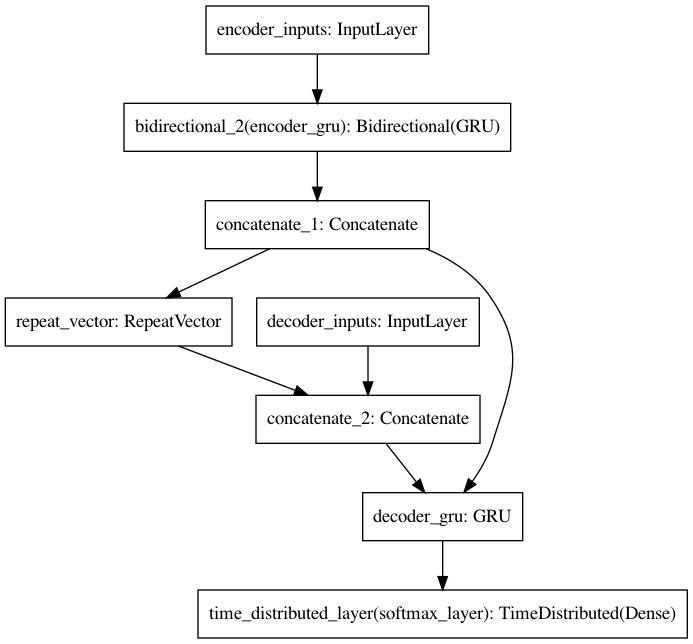

In [36]:
plot_model(full_model4)

### Training

In [37]:
# Run training
full_model4.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history4 = full_model4.fit([encoder_input_onehot, decoder_input_onehot], decoder_output_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/20
563/563 [==============================] - 71s 118ms/step - loss: 1.5673 - accuracy: 0.4403 - val_loss: 1.0928 - val_accuracy: 0.5806
Epoch 2/20
563/563 [==============================] - 67s 119ms/step - loss: 0.9760 - accuracy: 0.6297 - val_loss: 0.6799 - val_accuracy: 0.7262
Epoch 3/20
563/563 [==============================] - 66s 118ms/step - loss: 0.5441 - accuracy: 0.7810 - val_loss: 0.3843 - val_accuracy: 0.8413
Epoch 4/20
563/563 [==============================] - 66s 117ms/step - loss: 0.3012 - accuracy: 0.8832 - val_loss: 0.2380 - val_accuracy: 0.9151
Epoch 5/20
563/563 [==============================] - 60s 107ms/step - loss: 0.1979 - accuracy: 0.9297 - val_loss: 0.1471 - val_accuracy: 0.9485
Epoch 6/20
563/563 [==============================] - 74s 131ms/step - loss: 0.1393 - accuracy: 0.9537 - val_loss: 0.1138 - val_accuracy: 0.9599
Epoch 7/20
563/563 [==============================] - 62s 110ms/step - loss: 0.0996 - accuracy: 0.9678 - val_loss: 0.0682 - val_ac

## Model 5 (Attention)

![](../images/seq2seq-attention.jpeg)

### Define Model

In [38]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(input_maxlen, input_vsize), name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen-1, target_vsize), name='decoder_inputs')
# Encoder GRU
encoder_gru = GRU(latent_dim, return_sequences=True, return_state=True, name='encoder_gru')
encoder_out, encoder_state = encoder_gru(encoder_inputs)

# Set up the decoder GRU, using `encoder_states` as initial state.
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True, name='decoder_gru')
decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Attention layer
# attn_layer = AttentionLayer(name='attention_layer')
attn_layer = AdditiveAttention(name="attention_layer")

## The input for AdditiveAttention: query, key
## It returns a tensor of shape as query
## This is different from the AttentionLayer developed by Thushan
# attn_out, attn_states = attn_layer([encoder_out, decoder_out])

attn_out, attn_states  = attn_layer([decoder_out,encoder_out],return_attention_scores=True)

# Concat attention input and decoder GRU output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_concat_input)

# Full model
full_model5 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

full_model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, 7, 256), (No 208896      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, 5, 256), (No 208128      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

### Training

In [39]:
# Run training
full_model5.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history5 = full_model5.fit([encoder_input_onehot, decoder_input_onehot], decoder_output_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/20
563/563 [==============================] - 23s 35ms/step - loss: 1.5916 - accuracy: 0.4337 - val_loss: 1.3231 - val_accuracy: 0.5064
Epoch 2/20
563/563 [==============================] - 20s 35ms/step - loss: 1.2331 - accuracy: 0.5385 - val_loss: 1.0861 - val_accuracy: 0.5762
Epoch 3/20
563/563 [==============================] - 20s 36ms/step - loss: 0.9847 - accuracy: 0.6247 - val_loss: 0.8663 - val_accuracy: 0.6660
Epoch 4/20
563/563 [==============================] - 18s 33ms/step - loss: 0.8370 - accuracy: 0.6787 - val_loss: 0.7660 - val_accuracy: 0.7030
Epoch 5/20
563/563 [==============================] - 18s 32ms/step - loss: 0.7310 - accuracy: 0.7211 - val_loss: 0.6886 - val_accuracy: 0.7362
Epoch 6/20
563/563 [==============================] - 18s 32ms/step - loss: 0.6471 - accuracy: 0.7545 - val_loss: 0.6243 - val_accuracy: 0.7576
Epoch 7/20
563/563 [==============================] - 21s 37ms/step - loss: 0.5687 - accuracy: 0.7809 - val_loss: 0.5633 - val_accuracy:

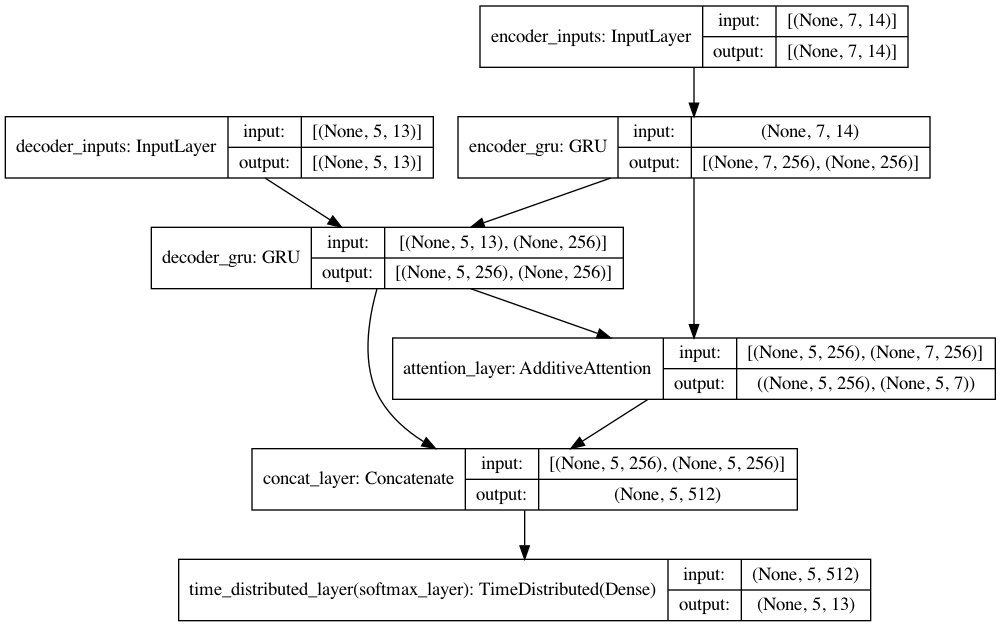

In [40]:
plot_model(full_model5, show_shapes=True)

In [41]:
full_model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, 7, 256), (No 208896      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, 5, 256), (No 208128      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

## Save Models

In [42]:
# # Save model
full_model5.save('keras_models/s2s-addition-attention.h5')

## Interim Comparison

In [43]:
history = [history1, history2, history3, history4, history5]
history = [i.history for i in history]
model_names = ['VanilaRNN','GRU', 'Birdirectional', 'Peeky', 'Attention']


In [44]:
import pickle

with open('keras_models/s2s-attention-addition-history', 'wb') as f:
    pickle.dump(history, f)
    

In [45]:
with open('keras_models/s2s-attention-addition-history','rb') as f:
    history = pickle.load(f)

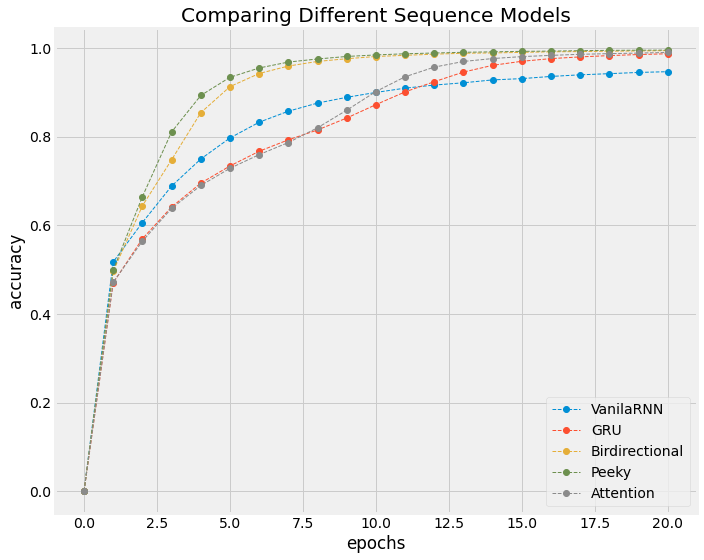

In [46]:
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10,8))
plt.style.use('fivethirtyeight')
for i, a in enumerate(acc):
    plt.plot(range(len(a)+1), [0] + a,
             linestyle='--', marker='o', linewidth=1, label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

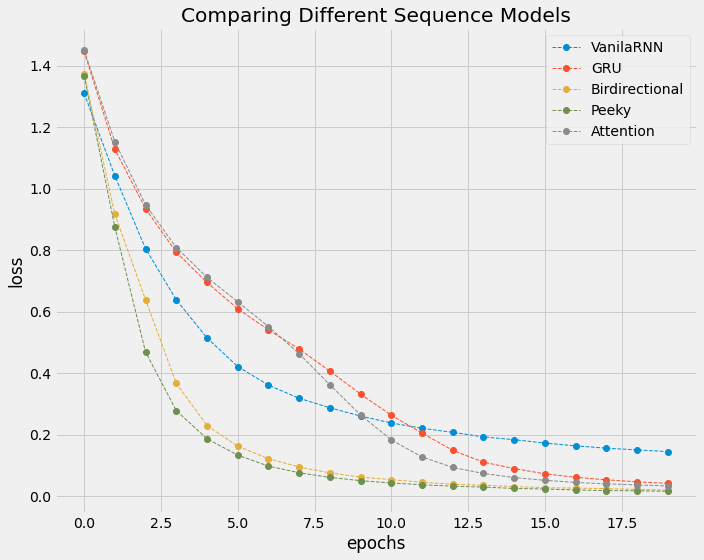

In [72]:
loss = [i['loss'] for i in history]


plt.figure(figsize=(10,8))
plt.style.use('fivethirtyeight')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),  a,
             linestyle='--', marker='o', linewidth=1, label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()

## Attention Model Analysis

In [48]:
full_model = full_model5

## Inference 

In [49]:
## If the model is loaded via external files
## Load the encoder_model, decoder_model this way
# from keras.models import load_model
# full_model5.load_weights('keras_models/s2s-addition-attention.h5')

### Inference Encoder

In [50]:
""" Inference model """
""" Encoder (Inference) model """
encoder_inf_inputs = full_model.input[0]
encoder_inf_out, encoder_inf_state = full_model.layers[2].output
encoder_inf_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

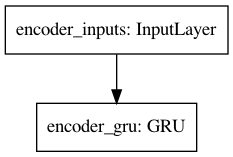

In [51]:
plot_model(encoder_inf_model)

### Inference Decoder

- The attention weights refer to at each time step, the relevance of the decoder output h and all the encoder output h's. Therefore, the shape of the attention weights should be `(input_maxlen,)`

In [52]:
""" Decoder (Inference) model """
decoder_inf_inputs = Input(shape=(1, target_vsize), name='decoder_inf_inputs') ## first target charcater
encoder_inf_states = Input(shape=(input_maxlen, latent_dim), name='encoder_inf_states') ## initial h's from encoder
decoder_init_state = Input(shape=(latent_dim), name='decoder_init') ## initial c from encoder

decoder_inf_gru = full_model.layers[3]
decoder_inf_out, decoder_inf_state = decoder_inf_gru(decoder_inf_inputs, 
                                                     initial_state=decoder_init_state)
# attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
decoder_inf_attention = full_model.layers[4]
attn_inf_out, attn_inf_states  = decoder_inf_attention([decoder_inf_out, encoder_inf_states],return_attention_scores=True)

decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
decoder_inf_timedense = full_model.layers[6]
decoder_inf_pred = decoder_inf_timedense(decoder_inf_concat)
decoder_inf_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
                      outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])



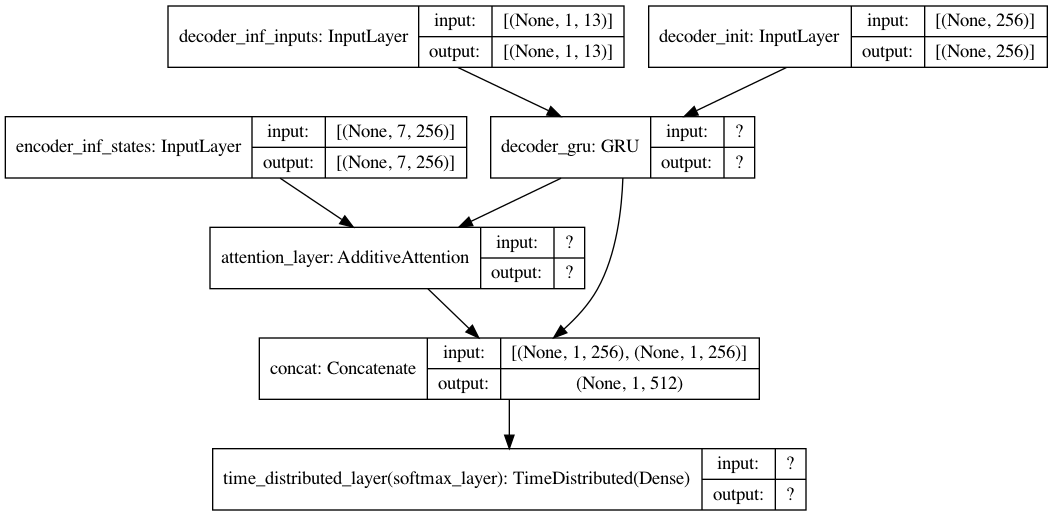

In [53]:
plot_model(decoder_inf_model, show_shapes=True)

In [54]:
def decode_sequence(input_seq):
    
    ## Initialize target output character "_"
#     test_dec_onehot_seq = np.zeros((1,1,target_vsize))
#     test_dec_onehot_seq[0,0, target_tokenizer.word_index.get('_')]=1.0
    initial_text = ['_']
    initial_seq = target_tokenizer.texts_to_sequences([initial_text])
    #initial_seq = pad_sequences(initial_seq, padding='post', maxlen = target_maxlen)
    test_dec_onehot_seq= np.expand_dims(
        to_categorical(initial_seq, num_classes=target_vsize),1)

    ## Encoder Inference
    enc_outs, enc_last_state = encoder_inf_model.predict(input_seq)

    ## Update decoder initial state
    dec_state = enc_last_state

    ## Holder for attention weights and decoded texts
    attention_weights = []
    dec_text = ''

    for i in range(target_maxlen):
        dec_out, attention, dec_state = decoder_inf_model.predict(
            [enc_outs, dec_state, test_dec_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]
        
        
        if dec_ind == 0:
            break

#         test_dec_onehot_seq = np.zeros((1,1,target_vsize))
#         test_dec_onehot_seq[0,0, dec_ind]=1.0
        initial_text = [dec_index2word[dec_ind]]
        initial_seq = target_tokenizer.texts_to_sequences([initial_text])
        #initial_seq = pad_sequences(initial_seq, padding='post', maxlen = target_maxlen)
        test_dec_onehot_seq= np.expand_dims(
            to_categorical(initial_seq, num_classes=target_vsize),1)


        attention_weights.append((dec_ind, attention))

        ## append the predicted char
        dec_text += dec_index2word[dec_ind]

    return dec_text, attention_weights

In [55]:
decoder_input_onehot[0:1,:,:]

array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
      dtype=float32)

In [56]:
encoder_input_onehot[0:10,:,:].shape

(10, 7, 14)

In [57]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    decoded_sentence,_ = decode_sequence(encoder_input_onehot[seq_index:seq_index + 1,:,:])
    print('-')
    print('Input sentence:', tr_input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 27+673 
Decoded sentence: 700_
-
Input sentence: 153+27 
Decoded sentence: 170_
-
Input sentence: 93+901 
Decoded sentence: 994_
-
Input sentence: 243+678
Decoded sentence: 921_
-
Input sentence: 269+46 
Decoded sentence: 315_
-
Input sentence: 235+891
Decoded sentence: 1126_
-
Input sentence: 46+290 
Decoded sentence: 336_
-
Input sentence: 324+947
Decoded sentence: 1271_
-
Input sentence: 721+49 
Decoded sentence: 779_
-
Input sentence: 535+7  
Decoded sentence: 542_
-
Input sentence: 45+117 
Decoded sentence: 162_
-
Input sentence: 669+174
Decoded sentence: 843_
-
Input sentence: 904+7  
Decoded sentence: 911_
-
Input sentence: 22+731 
Decoded sentence: 753_
-
Input sentence: 83+742 
Decoded sentence: 825_
-
Input sentence: 808+769
Decoded sentence: 1577_
-
Input sentence: 240+42 
Decoded sentence: 282_
-
Input sentence: 18+44  
Decoded sentence: 62_
-
Input sentence: 4+166  
Decoded sentence: 170_
-
Input sentence: 731+13 
Decoded sentence: 744_


## Plotting Attention

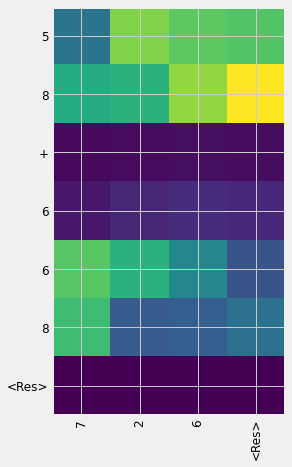

In [66]:
ind = 500
doc_inputs, attention_weights = decode_sequence(encoder_input_onehot[ind:ind+1,:,:])
mats = []
dec_inputs = []
for dec_ind, attn in attention_weights:
    mats.append(attn.reshape(-1))
    dec_inputs.append(dec_ind)
attention_mat = np.transpose(np.array(mats))
fig, ax = plt.subplots(figsize=(5,7 ))
ax.imshow(attention_mat)

ax.set_xticks(np.arange(attention_mat.shape[1]))
ax.set_yticks(np.arange(attention_mat.shape[0]))

ax.set_xticklabels([dec_index2word[inp] if inp != 2 else "<Res>" for inp in dec_inputs])
ax.set_yticklabels([enc_index2word[inp] if inp != 2 else "<Res>" for inp in encoder_input_sequences[ind]])

ax.tick_params(labelsize=12)
ax.tick_params(axis='x', labelrotation=90)


## Evaluation on Testing Data

- Wrap data preprocessing in a function

In [59]:
def preprocess_data(enc_tokenizer, dec_tokenizer, enc_text, dec_text, enc_maxlen, dec_maxlen, enc_vsize, dec_vsize):
    enc_seq = enc_tokenizer.texts_to_sequences(enc_text)
    enc_seq = pad_sequences(enc_seq, padding='post', maxlen = enc_maxlen)
    enc_onehot = to_categorical(enc_seq,num_classes=enc_vsize)
    
    dec_seq = dec_tokenizer.texts_to_sequences(dec_text)
    dec_seq = pad_sequences(dec_seq, padding='post', maxlen = dec_maxlen)
    dec_onehot = to_categorical(dec_seq, num_classes=dec_vsize)
    return enc_onehot, dec_onehot

In [60]:
ts_encoder_input_onehot, ts_decoder_target_onehot = preprocess_data(
    input_tokenizer, target_tokenizer, ts_input_texts, ts_target_texts,
    input_maxlen, target_maxlen, input_vsize, target_vsize)

In [61]:
print(ts_encoder_input_onehot.shape)
print(ts_decoder_target_onehot.shape)

(5000, 7, 14)
(5000, 6, 13)


In [62]:
full_model.evaluate([ts_encoder_input_onehot, ts_decoder_target_onehot[:,:-1,:]], ts_decoder_target_onehot[:,1:,:],
                   batch_size=batch_size, verbose=2)

79/79 - 1s - loss: 0.0691 - accuracy: 0.9761


[0.06909798830747604, 0.9760800004005432]

## References

- [Attention? Attention!](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)
- Bahdanau Attention Layber developed in [Thushan](https://github.com/thushv89/attention_keras)
- Thushan Ganegedara's [Attention in Deep Networks with Keras](https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39)
- This is based on Chapter 7 of [Deep Learning 2用 Python 進行自然語言處理的基礎理論實作](https://www.tenlong.com.tw/products/9789865020675)